## Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

## Load the Dataset

In [8]:
BASE_DIR = r"C:\Users\VICTUS\Age_Gender\utkface_aligned_cropped\UTKFace"

In [9]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [10]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,C:\Users\VICTUS\Age_Gender\utkface_aligned_cro...,100,0
1,C:\Users\VICTUS\Age_Gender\utkface_aligned_cro...,100,0
2,C:\Users\VICTUS\Age_Gender\utkface_aligned_cro...,100,1
3,C:\Users\VICTUS\Age_Gender\utkface_aligned_cro...,100,1
4,C:\Users\VICTUS\Age_Gender\utkface_aligned_cro...,100,1


In [11]:
gender_dict = {0:'Male', 1:'Female'}

## Exploratory Data Analysis

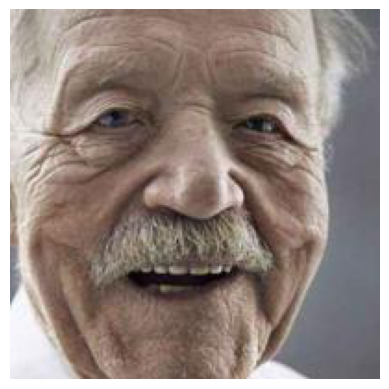

In [12]:
from PIL import Image
img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

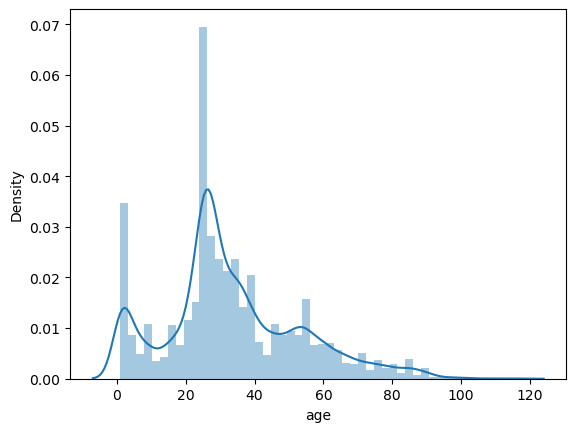

In [13]:
sns.distplot(df['age'])

<Axes: ylabel='count'>

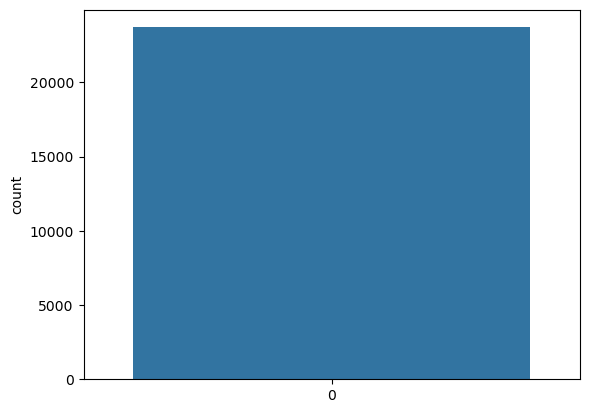

In [14]:
sns.countplot(df['gender'])

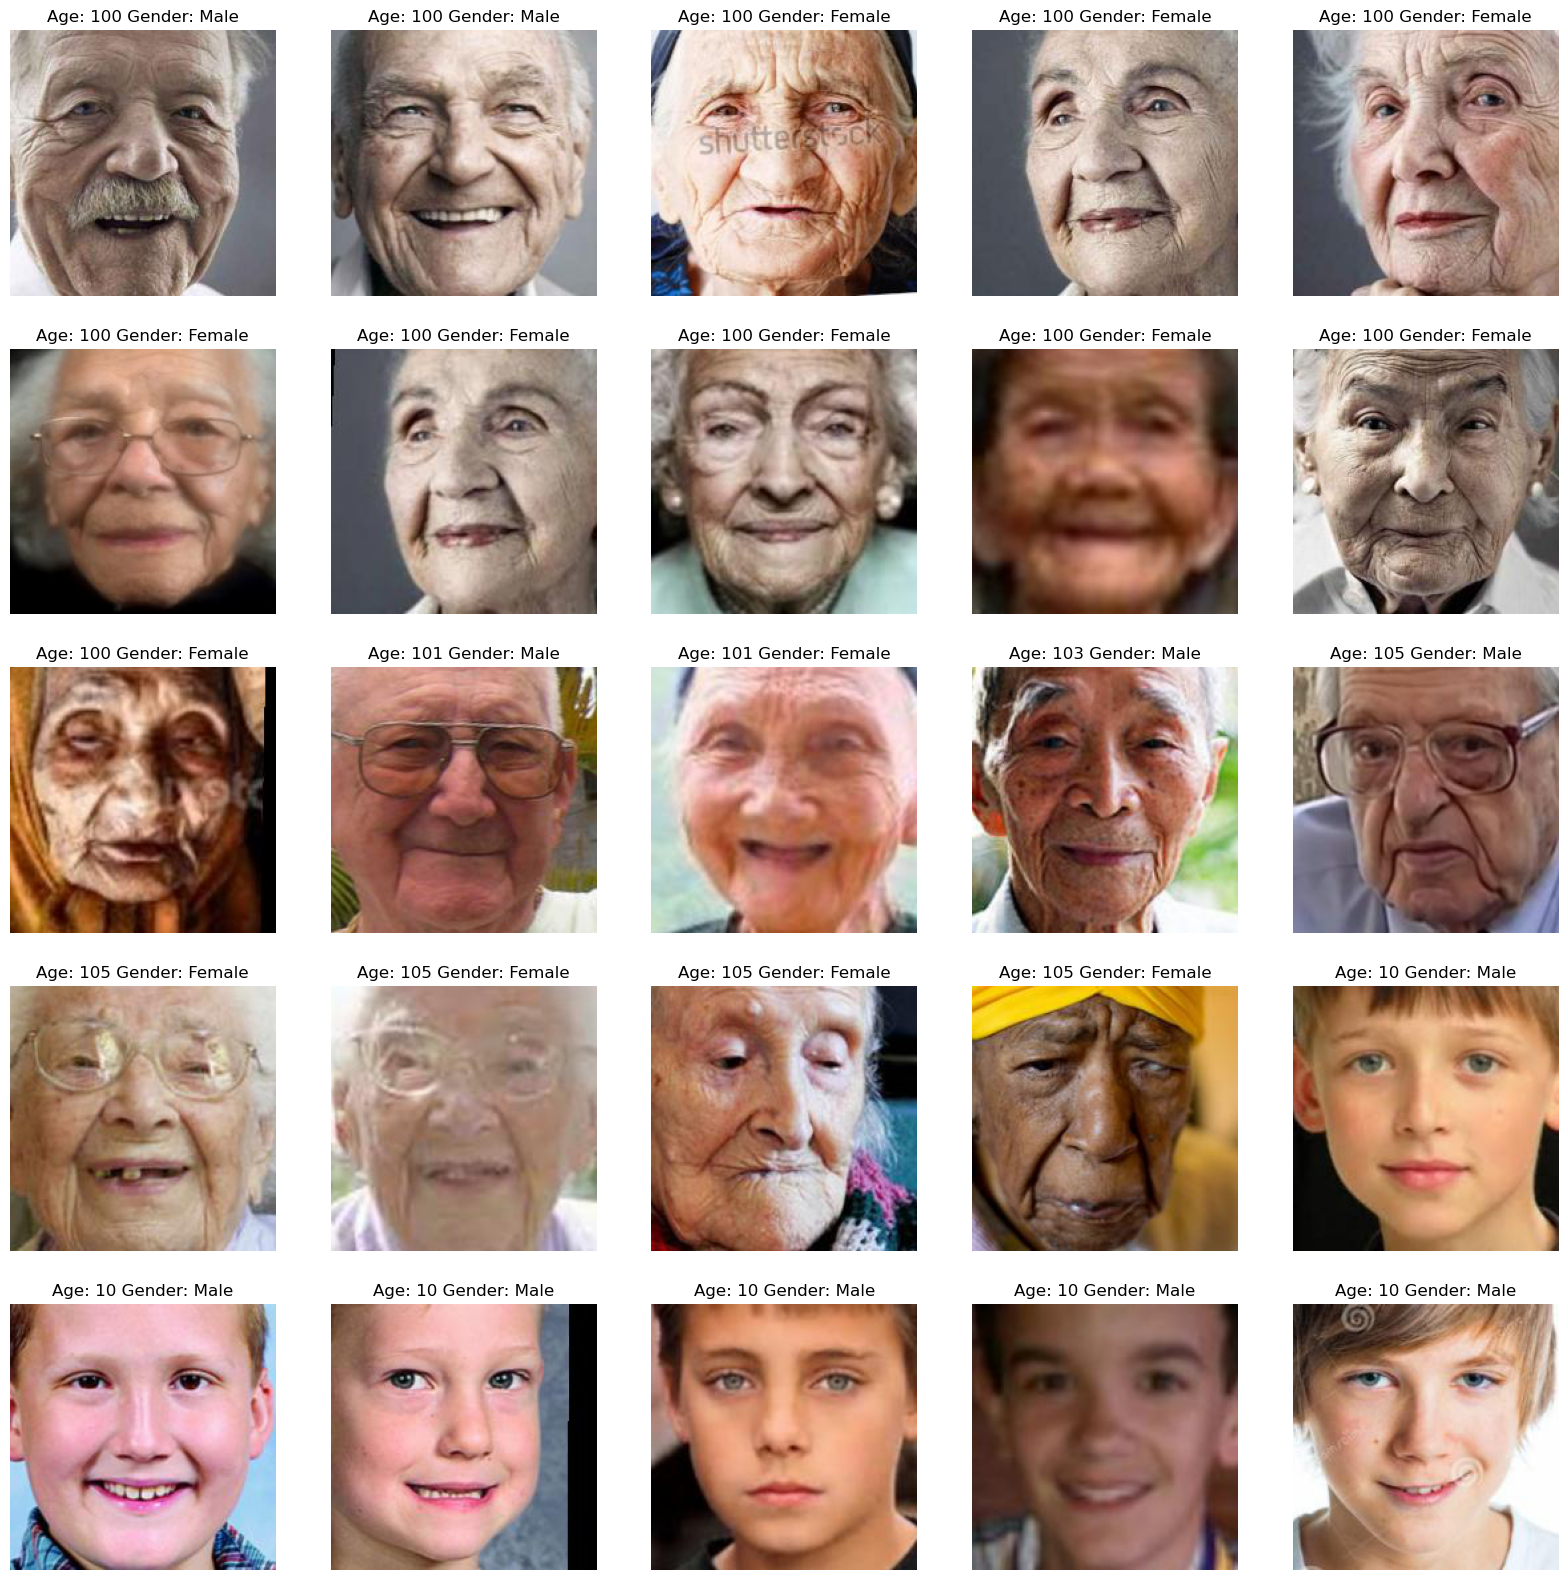

In [15]:
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

## Feature Extraction

In [18]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [19]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [20]:
X.shape

(23708, 128, 128, 1)

In [21]:
# normalize the images
X = X/255.0

In [22]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [23]:
input_shape = (128, 128, 1)

## Model Creation

In [24]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.4) (dense_1)
dropout_2 = Dropout(0.4) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

In [26]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=30, validation_split=0.2)

Epoch 1/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 104s 171ms/step - age_out_mae: 11.6235 - gender_out_accuracy: 0.5142 - loss: 12.3484 - val_age_out_mae: 34.2807 - val_gender_out_accuracy: 0.5812 - val_loss: 34.9728
Epoch 2/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 99s 167ms/step - age_out_mae: 9.1772 - gender_out_accuracy: 0.6086 - loss: 9.8079 - val_age_out_mae: 30.5485 - val_gender_out_accuracy: 0.7512 - val_loss: 31.0603
Epoch 3/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 100s 168ms/step - age_out_mae: 7.5312 - gender_out_accuracy: 0.7961 - loss: 7.9624 - val_age_out_mae: 27.7652 - val_gender_out_accuracy: 0.7845 - val_loss: 28.2327
Epoch 4/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 104s 175ms/step - age_out_mae: 6.7969 - gender_out_accuracy: 0.8287 - loss: 7.1655 - val_age_out_mae: 26.6226 - val_gender_out_accuracy: 0.7914 - val_loss: 27.0796
Epoch 5/30
593/593 ━━━━━━━━━━━━━━━━━━━━ 103s 174ms/step - age_out_mae: 6.3314 - gender_out_accuracy: 0.8543 - loss: 6.6506 - val_age_out_mae: 24.3392 - val_gender_out_accuracy: 0.7973

In [34]:
model.save("age_gender_model.keras")
print("Model saved successfully!")

Model saved successfully!


## Plot the Results

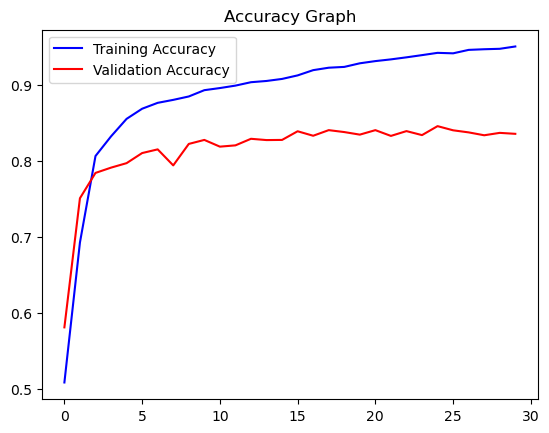

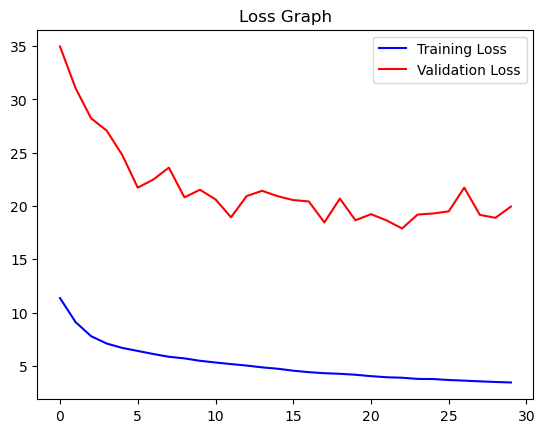

In [35]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

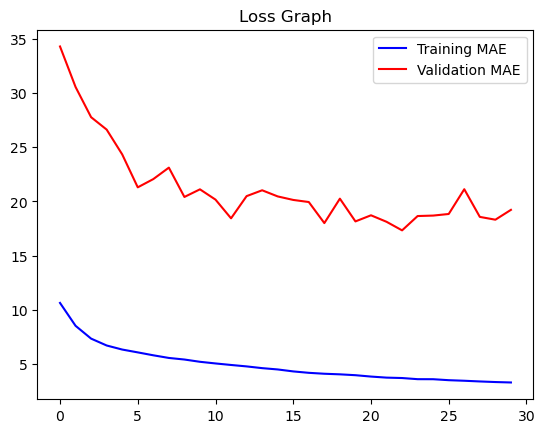

In [36]:
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

# Prediction with Test Data

Original Gender: Male Original Age: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Predicted Gender: Male Predicted Age: 12


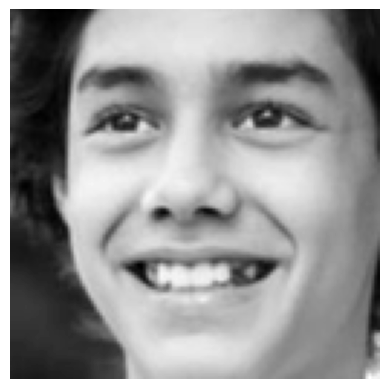

In [37]:
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predicted Gender: Male Predicted Age: 20


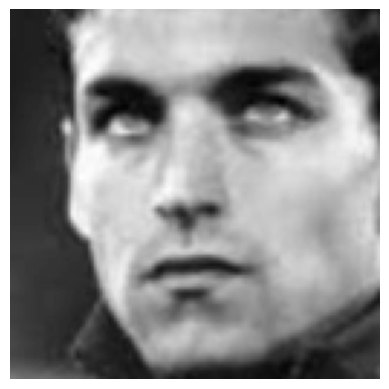

In [38]:
image_index = 3000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Gender: Female Predicted Age: 29


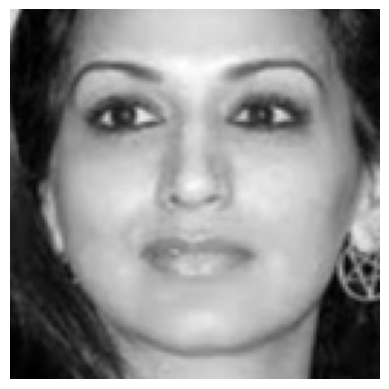

In [39]:
image_index = 10000
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');